# Prescriptive Analytics — Transportation LP (Solutions)

## Imports & Baseline Data

In [4]:
!pip -q install pulp

In [8]:
# ============================================================
# === Cell 1: Setup – base data, solver function, baseline ===
# ============================================================

import pandas as pd, numpy as np
import pulp
import matplotlib.pyplot as plt
# --- Step 1: Define base supply, demand, and costs ---
# (Same spirit as your original code; we wrap it so we can reuse it.)

dcs_base = pd.DataFrame({
    "DC": ["DC_East", "DC_West"],
    "Supply": [610, 200]      # Total available from each DC
})

stores_base = pd.DataFrame({
    "Store":  ["Store_A", "Store_B", "Store_C", "Store_D"],
    "Demand": [251,        300,       35,       20]        # Required at each store
})

cost_base = pd.DataFrame({
    "DC": ["DC_East", "DC_West"],
    "Store_A": [4, 6],
    "Store_B": [5, 4],
    "Store_C": [7, 3],
    "Store_D": [6, 5]
})

# --- Step 2: Helper function to build & solve the LP model ---
def solve_transport(dcs, stores, cost, scenario_name="Scenario", max_dc_west=None):
    """
    Build and solve the transportation LP for a given scenario.
    
    Parameters:
      dcs          : DataFrame with columns ["DC", "Supply"]
      stores       : DataFrame with columns ["Store", "Demand"]
      cost         : DataFrame with 'DC' + one column per Store
      scenario_name: Name printed for clarity
      max_dc_west  : Optional upper bound on total shipments from DC_West
    Returns:
      total_cost, flow_df (DC, Store, Qty)
    """
    print("=" * 70)
    print(f"{scenario_name}")
    print("-" * 70)
    
    # Step A: Create model and decision variables
    prob = pulp.LpProblem("Transportation", pulp.LpMinimize)
    x = {(dc, st): pulp.LpVariable(f"x_{dc}_{st}", lowBound=0)
         for dc in dcs["DC"] for st in stores["Store"]}
    
    # Step B: Objective function – minimize total transport cost
    prob += pulp.lpSum(
        float(cost.loc[cost["DC"] == dc, st]) * x[(dc, st)]
        for dc in dcs["DC"] for st in stores["Store"]
    )
    
    # Step C: Supply constraints – each DC cannot ship more than its supply
    for _, row in dcs.iterrows():
        dc = row["DC"]
        prob += pulp.lpSum(x[(dc, st)] for st in stores["Store"]) <= row["Supply"], f"Supply_{dc}"
    
    # Step D: Demand constraints – each store must receive exactly its demand
    for _, row in stores.iterrows():
        st = row["Store"]
        prob += pulp.lpSum(x[(dc, st)] for dc in dcs["DC"]) == row["Demand"], f"Demand_{st}"
    
    # Step E (Optional): Capacity constraint for DC_West (Combined Constraint scenario)
    if max_dc_west is not None:
        prob += pulp.lpSum(x[("DC_West", st)] for st in stores["Store"]) <= max_dc_west, "Max_DC_West"
    
    # Step F: Solve the LP
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    status = pulp.LpStatus[prob.status]
    print(f"Solver Status: {status}")
    if status != "Optimal":
        print("⚠️ No optimal solution found. Check feasibility (supply vs demand).")
    
    total_cost = pulp.value(prob.objective)
    print(f"Total Transportation Cost (EUR): {total_cost:.2f}")
    
    # Step G: Extract shipment plan
    rows = []
    for dc in dcs["DC"]:
        for st in stores["Store"]:
            qty = x[(dc, st)].value()
            if qty > 1e-6:  # ignore tiny numerical noise
                rows.append((dc, st, qty))
    flow_df = pd.DataFrame(rows, columns=["DC", "Store", "Qty"])
    print("\nOptimal Shipment Plan (Qty in units):")
    print(flow_df)
    
    # Step H: Show how much each DC ships in total (for intuition)
    print("\nTotal shipped from each DC:")
    print(flow_df.groupby("DC")["Qty"].sum())
    
    # Step I: Show how much each store receives (should match demand)
    print("\nTotal received by each Store:")
    print(flow_df.groupby("Store")["Qty"].sum())
    
    return total_cost, flow_df

# --- Step 3: Baseline solution (for comparison later) ---
baseline_cost, baseline_flow = solve_transport(
    dcs_base, stores_base, cost_base, scenario_name="Baseline Scenario (no changes)"
)
print("\nBaseline cost will be used as reference for all what-if questions.")
print(f"Baseline Cost (EUR): {baseline_cost:.2f}")

# --- Plotting helper: grouped bar chart of shipments ---


def plot_shipments(flow_df, title="Optimal Shipments"):
    """
    Creates a grouped bar chart showing DC → Store shipments.
    """
    pivot = flow_df.pivot(index="Store", columns="DC", values="Qty").fillna(0)

    pivot.plot(kind="bar", figsize=(7,4))
    plt.title(title)
    plt.xlabel("Store")
    plt.ylabel("Units Shipped")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


Baseline Scenario (no changes)
----------------------------------------------------------------------
Solver Status: Optimal
Total Transportation Cost (EUR): 2564.00

Optimal Shipment Plan (Qty in units):
        DC    Store    Qty
0  DC_East  Store_A  251.0
1  DC_East  Store_B  155.0
2  DC_West  Store_B  145.0
3  DC_West  Store_C   35.0
4  DC_West  Store_D   20.0

Total shipped from each DC:
DC
DC_East    406.0
DC_West    200.0
Name: Qty, dtype: float64

Total received by each Store:
Store
Store_A    251.0
Store_B    300.0
Store_C     35.0
Store_D     20.0
Name: Qty, dtype: float64

Baseline cost will be used as reference for all what-if questions.
Baseline Cost (EUR): 2564.00


/var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/ipykernel_18259/98861627.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(cost.loc[cost["DC"] == dc, st]) * x[(dc, st)]


Updated DC supplies (after capacity reduction):
        DC  Supply
0  DC_East     500
1  DC_West     200
Q1: Capacity Reduction – DC_East supply 610 → 500
----------------------------------------------------------------------
Solver Status: Optimal
Total Transportation Cost (EUR): 2564.00

Optimal Shipment Plan (Qty in units):
        DC    Store    Qty
0  DC_East  Store_A  251.0
1  DC_East  Store_B  155.0
2  DC_West  Store_B  145.0
3  DC_West  Store_C   35.0
4  DC_West  Store_D   20.0

Total shipped from each DC:
DC
DC_East    406.0
DC_West    200.0
Name: Qty, dtype: float64

Total received by each Store:
Store
Store_A    251.0
Store_B    300.0
Store_C     35.0
Store_D     20.0
Name: Qty, dtype: float64

--- Comparison to Baseline ---
Baseline Cost (EUR): 2564.00
Q1 Cost (EUR):       2564.00
Cost Change (EUR):   0.00

Interpretation:
- We reduced available capacity at DC_East.
- The optimizer shifts more flow to DC_West if needed,
while still meeting all store demands at minimal total

/var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/ipykernel_18259/98861627.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(cost.loc[cost["DC"] == dc, st]) * x[(dc, st)]


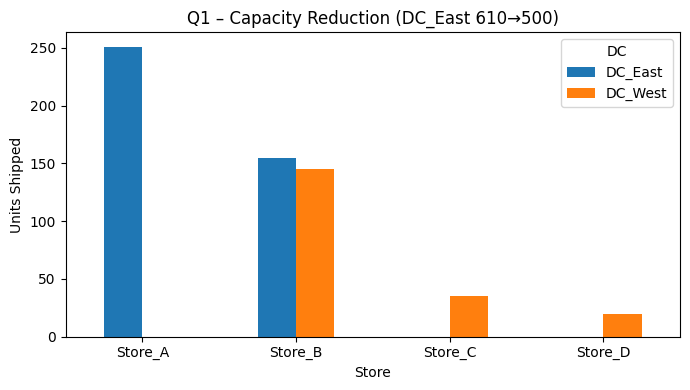

In [9]:
# ============================================================
# ===  Question 1 – Capacity Reduction at DC_East    ===
#        Decrease DC_East supply and re-solve the model      #
# ============================================================

# Step 1: Copy base data so we don’t modify the original
dcs_q1 = dcs_base.copy()
stores_q1 = stores_base.copy()
cost_q1 = cost_base.copy()

# Step 2: Apply the change
# In your text: 600 → 500. In our toy data DC_East has 610;
# we simulate a capacity cut from 610 to 500.
dcs_q1.loc[dcs_q1["DC"] == "DC_East", "Supply"] = 500

print("Updated DC supplies (after capacity reduction):")
print(dcs_q1)

# Step 3: Solve the modified model
q1_cost, q1_flow = solve_transport(
    dcs_q1, stores_q1, cost_q1,
    scenario_name="Q1: Capacity Reduction – DC_East supply 610 → 500"
)

# Step 4: Compare to baseline
print("\n--- Comparison to Baseline ---")
print(f"Baseline Cost (EUR): {baseline_cost:.2f}")
print(f"Q1 Cost (EUR):       {q1_cost:.2f}")
print(f"Cost Change (EUR):   {q1_cost - baseline_cost:.2f}")

print("\nInterpretation:")
print("- We reduced available capacity at DC_East.")
print("- The optimizer shifts more flow to DC_West if needed,")
print("while still meeting all store demands at minimal total cost.")

plot_shipments(q1_flow, title="Q1 – Capacity Reduction (DC_East 610→500)")



## Scenario 2 — Demand Spike (Store_C 35 → 450)

Updated store demands (after demand spike at Store_C):
     Store  Demand
0  Store_A     251
1  Store_B     300
2  Store_C     450
3  Store_D      20
Q2: Demand Spike – Store_C demand 35 → 450
----------------------------------------------------------------------
Solver Status: Infeasible
⚠️ No optimal solution found. Check feasibility (supply vs demand).
Total Transportation Cost (EUR): 4974.00

Optimal Shipment Plan (Qty in units):
        DC    Store    Qty
0  DC_East  Store_A  251.0
1  DC_East  Store_B  300.0
2  DC_East  Store_C  250.0
3  DC_East  Store_D   20.0
4  DC_West  Store_C  200.0

Total shipped from each DC:
DC
DC_East    821.0
DC_West    200.0
Name: Qty, dtype: float64

Total received by each Store:
Store
Store_A    251.0
Store_B    300.0
Store_C    450.0
Store_D     20.0
Name: Qty, dtype: float64

--- Comparison to Baseline ---
Baseline Cost (EUR): 2564.00
Q2 Cost (EUR):       4974.00
Cost Change (EUR):   2410.00

Interpretation:
- Store_C now needs more units.


/var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/ipykernel_18259/98861627.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(cost.loc[cost["DC"] == dc, st]) * x[(dc, st)]


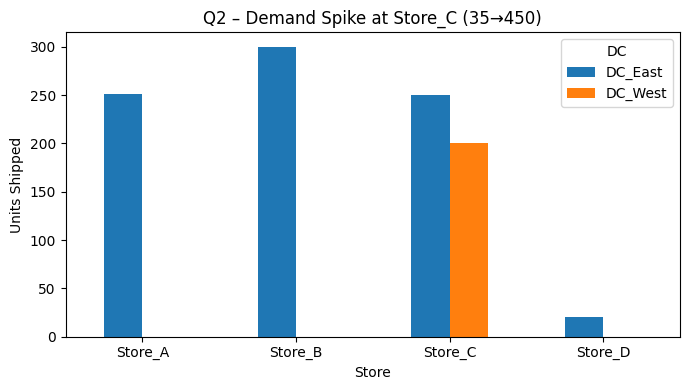

In [11]:
# ============================================================
# ===  Question 2 – Demand Spike at Store_C         ===
#        Increase Store_C demand and check solution         #
# ============================================================

# Step 1: Copy base data
dcs_q2 = dcs_base.copy()
stores_q2 = stores_base.copy()
cost_q2 = cost_base.copy()

# Step 2: Apply the demand spike
# Your text: 350 → 450 units. Our toy dataset uses 35,
# so we increase Store_C demand from 35 → 450 units (same idea).
stores_q2.loc[stores_q2["Store"] == "Store_C", "Demand"] = 450

print("Updated store demands (after demand spike at Store_C):")
print(stores_q2)

# Step 3: Solve the modified model
q2_cost, q2_flow = solve_transport(
    dcs_q2, stores_q2, cost_q2,
    scenario_name="Q2: Demand Spike – Store_C demand 35 → 450"
)

# Step 4: Compare to baseline
print("\n--- Comparison to Baseline ---")
print(f"Baseline Cost (EUR): {baseline_cost:.2f}")
print(f"Q2 Cost (EUR):       {q2_cost:.2f}")
print(f"Cost Change (EUR):   {q2_cost - baseline_cost:.2f}")

print("\nInterpretation:")
print("- Store_C now needs more units.")

plot_shipments(q2_flow, title="Q2 – Demand Spike at Store_C (35→450)")


## Scenario 3 — Cost Adjustment (+2 on all DC_West routes)

Updated cost matrix (after +2 on all DC_West routes):
        DC  Store_A  Store_B  Store_C  Store_D
0  DC_East        4        5        7        6
1  DC_West        8        6        5        7
Q3: Cost Adjustment – DC_West routes +2 EUR
----------------------------------------------------------------------
Solver Status: Optimal
Total Transportation Cost (EUR): 2799.00

Optimal Shipment Plan (Qty in units):
        DC    Store    Qty
0  DC_East  Store_A  251.0
1  DC_East  Store_B  300.0
2  DC_East  Store_D   20.0
3  DC_West  Store_C   35.0

Total shipped from each DC:
DC
DC_East    571.0
DC_West     35.0
Name: Qty, dtype: float64

Total received by each Store:
Store
Store_A    251.0
Store_B    300.0
Store_C     35.0
Store_D     20.0
Name: Qty, dtype: float64

--- Comparison to Baseline ---
Baseline Cost (EUR): 2564.00
Q3 Cost (EUR):       2799.00
Cost Change (EUR):   235.00

Interpretation:
- Shipping from DC_West became more expensive to every store.
- The optimizer prefers DC_East 

/var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/ipykernel_18259/98861627.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(cost.loc[cost["DC"] == dc, st]) * x[(dc, st)]


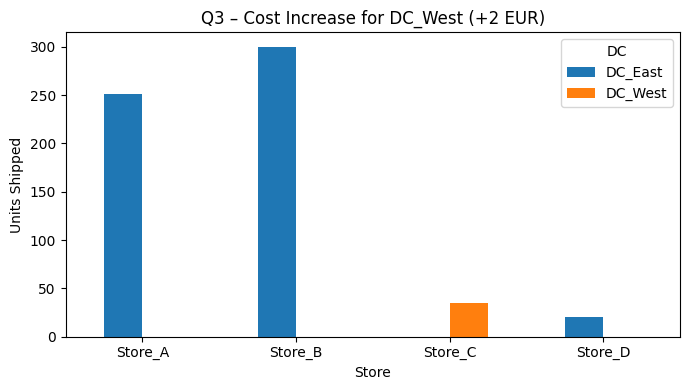

In [12]:
# ============================================================
# ===  Question 3 – Cost Adjustment for DC_West     ===
#        Add +2 EUR to all DC_West routes                   #
# ============================================================

# Step 1: Copy base data
dcs_q3 = dcs_base.copy()
stores_q3 = stores_base.copy()
cost_q3 = cost_base.copy()

# Step 2: Increase all shipping costs from DC_West by +2
store_cols = stores_q3["Store"].tolist()
mask_west = cost_q3["DC"] == "DC_West"
cost_q3.loc[mask_west, store_cols] = cost_q3.loc[mask_west, store_cols] + 2

print("Updated cost matrix (after +2 on all DC_West routes):")
print(cost_q3)

# Step 3: Solve the modified model
q3_cost, q3_flow = solve_transport(
    dcs_q3, stores_q3, cost_q3,
    scenario_name="Q3: Cost Adjustment – DC_West routes +2 EUR"
)

# Step 4: Compare to baseline
print("\n--- Comparison to Baseline ---")
print(f"Baseline Cost (EUR): {baseline_cost:.2f}")
print(f"Q3 Cost (EUR):       {q3_cost:.2f}")
print(f"Cost Change (EUR):   {q3_cost - baseline_cost:.2f}")

print("\nInterpretation:")
print("- Shipping from DC_West became more expensive to every store.")
print("- The optimizer prefers DC_East more (where feasible) to save cost.")
print("- Total cost usually goes up; check if flow from DC_West decreased.")

plot_shipments(q3_flow, title="Q3 – Cost Increase for DC_West (+2 EUR)")


## Scenario 4 — New DC Added (DC_North, supply 300)

Updated DC list (with DC_North):
         DC  Supply
0   DC_East     610
1   DC_West     200
2  DC_North     300

Updated cost matrix (including DC_North row):
         DC  Store_A  Store_B  Store_C  Store_D
0   DC_East        4        5        7        6
1   DC_West        6        4        3        5
2  DC_North        5        5        4        6
Q4: New DC_North added with 300 units
----------------------------------------------------------------------
Solver Status: Optimal
Total Transportation Cost (EUR): 2564.00

Optimal Shipment Plan (Qty in units):
         DC    Store    Qty
0   DC_East  Store_A  251.0
1   DC_East  Store_B  100.0
2   DC_East  Store_D   20.0
3   DC_West  Store_B  200.0
4  DC_North  Store_C   35.0

Total shipped from each DC:
DC
DC_East     371.0
DC_North     35.0
DC_West     200.0
Name: Qty, dtype: float64

Total received by each Store:
Store
Store_A    251.0
Store_B    300.0
Store_C     35.0
Store_D     20.0
Name: Qty, dtype: float64

--- Comparison to Baseli

/var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/ipykernel_18259/98861627.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(cost.loc[cost["DC"] == dc, st]) * x[(dc, st)]


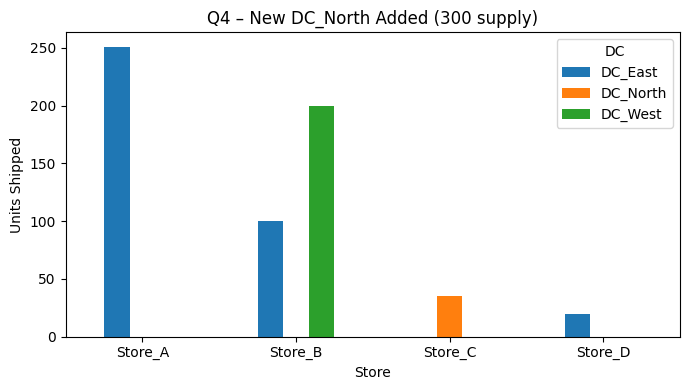

In [13]:
# ============================================================
# === Question 4 – New DC Added (DC_North)         ===
#        Introduce DC_North with 300 units supply           #
# ============================================================

# Step 1: Copy base data
dcs_q4 = dcs_base.copy()
stores_q4 = stores_base.copy()
cost_q4 = cost_base.copy()

# Step 2: Add a new DC with 300 units supply
dcs_q4 = pd.concat(
    [dcs_q4, pd.DataFrame({"DC": ["DC_North"], "Supply": [300]})],
    ignore_index=True
)

# Step 3: Add cost row for the new DC
# Here we *assume* some reasonable cost numbers for DC_North → Stores.
# You can change these to match your case.
new_dc_cost = pd.DataFrame({
    "DC": ["DC_North"],
    "Store_A": [5],
    "Store_B": [5],
    "Store_C": [4],
    "Store_D": [6]
})
cost_q4 = pd.concat([cost_q4, new_dc_cost], ignore_index=True)

print("Updated DC list (with DC_North):")
print(dcs_q4)
print("\nUpdated cost matrix (including DC_North row):")
print(cost_q4)

# Step 4: Solve the modified model
q4_cost, q4_flow = solve_transport(
    dcs_q4, stores_q4, cost_q4,
    scenario_name="Q4: New DC_North added with 300 units"
)

# Step 5: Compare to baseline
print("\n--- Comparison to Baseline ---")
print(f"Baseline Cost (EUR): {baseline_cost:.2f}")
print(f"Q4 Cost (EUR):       {q4_cost:.2f}")
print(f"Cost Change (EUR):   {q4_cost - baseline_cost:.2f}")

print("\nInterpretation:")
print("- We added a new warehouse (DC_North) with its own costs and capacity.")
print("- The optimizer chooses when to use DC_North versus DC_East / DC_West.")
print("- If DC_North has competitive costs to some stores, total cost decreases.")

plot_shipments(q4_flow, title="Q4 – New DC_North Added (300 supply)")


## Scenario 5 — Combined Constraint (Cap DC_West shipments ≤ 400)

We will restrict total shipments from DC_West to at most 400 units.
Q5: Combined Constraint – DC_West total ≤ 400
----------------------------------------------------------------------
Solver Status: Optimal
Total Transportation Cost (EUR): 2564.00

Optimal Shipment Plan (Qty in units):
        DC    Store    Qty
0  DC_East  Store_A  251.0
1  DC_East  Store_B  155.0
2  DC_West  Store_B  145.0
3  DC_West  Store_C   35.0
4  DC_West  Store_D   20.0

Total shipped from each DC:
DC
DC_East    406.0
DC_West    200.0
Name: Qty, dtype: float64

Total received by each Store:
Store
Store_A    251.0
Store_B    300.0
Store_C     35.0
Store_D     20.0
Name: Qty, dtype: float64

--- Comparison to Baseline ---
Baseline Cost (EUR): 2564.00
Q5 Cost (EUR):       2564.00
Cost Change (EUR):   0.00

Extra check on DC_West:
Baseline DC_West shipments: 200.00 units
Q5 DC_West shipments:       200.00 units

Interpretation:
- This is a combined scenario: normal model + extra capacity limit on DC_West.
- If bas

/var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/ipykernel_18259/98861627.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(cost.loc[cost["DC"] == dc, st]) * x[(dc, st)]


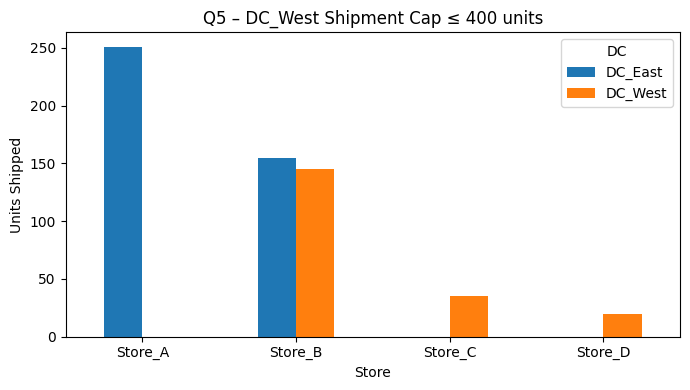

In [14]:
# ============================================================
# === Question 5 – Combined Constraint on DC_West  ===
#        Impose max 400 units shipped from DC_West          #
# ============================================================

# Step 1: Copy base data
dcs_q5 = dcs_base.copy()
stores_q5 = stores_base.copy()
cost_q5 = cost_base.copy()

# Step 2: Set an upper limit on total shipments from DC_West
max_dc_west_capacity = 400  # As per the question

print(f"We will restrict total shipments from DC_West to at most {max_dc_west_capacity} units.")

# Step 3: Solve the modified model with the extra constraint
q5_cost, q5_flow = solve_transport(
    dcs_q5, stores_q5, cost_q5,
    scenario_name=f"Q5: Combined Constraint – DC_West total ≤ {max_dc_west_capacity}",
    max_dc_west=max_dc_west_capacity
)

# Step 4: Compare to baseline
print("\n--- Comparison to Baseline ---")
print(f"Baseline Cost (EUR): {baseline_cost:.2f}")
print(f"Q5 Cost (EUR):       {q5_cost:.2f}")
print(f"Cost Change (EUR):   {q5_cost - baseline_cost:.2f}")

# Step 5: Interpret the result
# (We also check how much DC_West actually shipped.)
dc_west_shipped_baseline = baseline_flow.groupby("DC")["Qty"].sum().get("DC_West", 0)
dc_west_shipped_q5 = q5_flow.groupby("DC")["Qty"].sum().get("DC_West", 0)

print("\nExtra check on DC_West:")
print(f"Baseline DC_West shipments: {dc_west_shipped_baseline:.2f} units")
print(f"Q5 DC_West shipments:       {dc_west_shipped_q5:.2f} units")

print("\nInterpretation:")
print("- This is a combined scenario: normal model + extra capacity limit on DC_West.")
print("- If baseline DC_West shipments were > 400, the model must reroute flows")
print("  to DC_East (and/or DC_North if you combine with Q4) to respect the cap.")
print("- Total cost may increase because we are forcing a less flexible solution.")

plot_shipments(q5_flow, title="Q5 – DC_West Shipment Cap ≤ 400 units")
